In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [1]:
!nvidia-smi

Tue Oct 28 14:32:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!nvidia-smi
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Tue Oct 28 14:34:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image

In [4]:
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)

train_ds = dataset['train']
val_ds   = dataset['validation']
test_ds  = dataset['test']

print("Number of classes:", dataset_info.features['label'].num_classes)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.0A1Z0I_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.0A1Z0I_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.0A1Z0I_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
Number of classes: 102


In [5]:
def format_image(image, label):
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

BATCH_SIZE = 32
train_batches = train_ds.map(format_image).shuffle(1000).batch(BATCH_SIZE)
val_batches   = val_ds.map(format_image).batch(BATCH_SIZE)
test_batches  = test_ds.map(format_image).batch(BATCH_SIZE)

In [6]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3),
                                         trainable=False)

In [11]:
import tensorflow as tf
import tensorflow_hub as hub

num_classes = dataset_info.features['label'].num_classes

def hub_layer(x):
    hub_module = hub.load("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4")
    return hub_module(x)

inputs = tf.keras.Input(shape=(224,224,3))
x = tf.keras.layers.Lambda(hub_layer)(inputs)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 102)            │       130,662 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,662 (510.40 KB)

 Trainable params: 130,662 (510.40 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=5
)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 655ms/step - accuracy: 0.0330 - loss: 4.8288 - val_accuracy: 0.3765 - val_loss: 3.1005
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.5113 - loss: 2.5406 - val_accuracy: 0.6275 - val_loss: 2.0745
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.8025 - loss: 1.4542 - val_accuracy: 0.7284 - val_loss: 1.5620
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9156 - loss: 0.8588 - val_accuracy: 0.7539 - val_loss: 1.3149
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9532 - loss: 0.5758 - val_accuracy: 0.7735 - val_loss: 1.1642


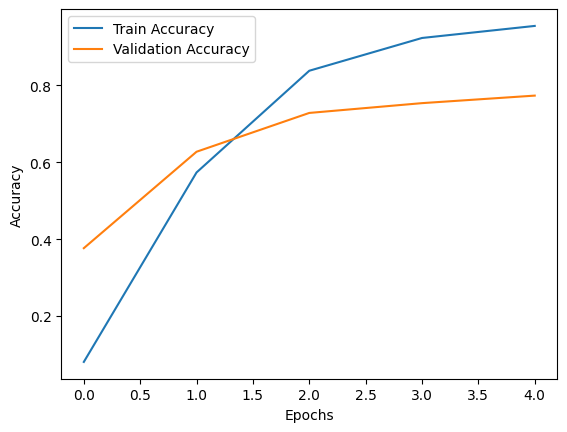

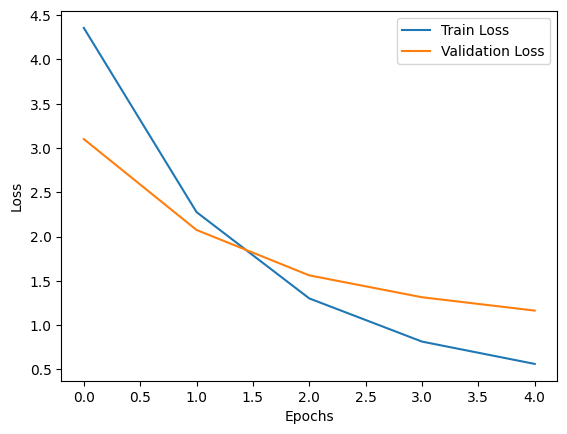

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
test_loss, test_acc = model.evaluate(test_batches)
print(f"\n Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")


193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.7459 - loss: 1.2901

 Test Accuracy: 0.75
Test Loss: 1.27


In [16]:
model.save('flower_model.h5')
print(" Model saved as flower_model.h5")


 Model saved as flower_model.h5


In [18]:
import json

with open('cat_to_name.json', 'r') as f:
    class_names = json.load(f)

print(" Loaded category names successfully!")
print(list(class_names.items())[:5])

 Loaded category names successfully!
[('21', 'fire lily'), ('3', 'canterbury bells'), ('45', 'bolero deep blue'), ('1', 'pink primrose'), ('34', 'mexican aster')]


In [19]:
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def process_image(image):
    image = tf.convert_to_tensor(image)
    image = tf.image.resize(image, (224,224))
    image = image / 255.0
    return image.numpy()

def predict(image_path, model, top_k=5):
    img = Image.open(image_path)
    processed = process_image(np.asarray(img))
    preds = model.predict(np.expand_dims(processed, axis=0))
    top_k_probs, top_k_classes = tf.nn.top_k(preds, k=top_k)
    return top_k_probs.numpy()[0], top_k_classes.numpy()[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


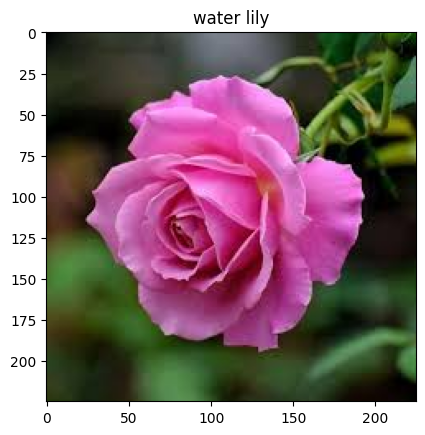

water lily: 23.29%
globe thistle: 12.33%
sweet william: 10.00%
bougainvillea: 7.42%
carnation: 7.38%


In [20]:
image_path = 'rose.jpg'
probs, classes = predict(image_path, model)

plt.imshow(Image.open(image_path))
plt.title(class_names[str(classes[0])])
plt.show()

for i in range(len(probs)):
    print(f"{class_names[str(classes[i])]}: {probs[i]*100:.2f}%")


In [22]:
!python predict.py rose.jpg flower_model.h5 --top_k 5 --category_names cat_to_name.json

2025-10-28 15:08:18.685832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761664098.703552   10942 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761664098.708990   10942 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761664098.723864   10942 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761664098.723890   10942 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761664098.723896   10942 computation_placer.cc:177] computation placer alr